In [ ]:
!gdown http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

Downloading...
From: http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
To: /content/images.tar.gz
100% 792M/792M [01:09<00:00, 11.4MB/s]


In [ ]:
!gdown http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

Downloading...
From: http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
To: /content/annotations.tar.gz
100% 19.2M/19.2M [00:03<00:00, 5.77MB/s]


In [ ]:
!tar -xf images.tar.gz

In [ ]:
!tar -xf annotations.tar.gz

In [ ]:
import os

input_dir = "/content/images/"
target_dir = "/content/annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
/content/images/Abyssinian_1.jpg | /content/annotations/trimaps/Abyssinian_1.png
/content/images/Abyssinian_10.jpg | /content/annotations/trimaps/Abyssinian_10.png
/content/images/Abyssinian_100.jpg | /content/annotations/trimaps/Abyssinian_100.png
/content/images/Abyssinian_101.jpg | /content/annotations/trimaps/Abyssinian_101.png
/content/images/Abyssinian_102.jpg | /content/annotations/trimaps/Abyssinian_102.png
/content/images/Abyssinian_103.jpg | /content/annotations/trimaps/Abyssinian_103.png
/content/images/Abyssinian_104.jpg | /content/annotations/trimaps/Abyssinian_104.png
/content/images/Abyssinian_105.jpg | /content/annotations/trimaps/Abyssinian_105.png
/content/images/Abyssinian_106.jpg | /content/annotations/trimaps/Abyssinian_106.png
/content/images/Abyssinian_107.jpg | /content/annotations/trimaps/Abyssinian_107.png


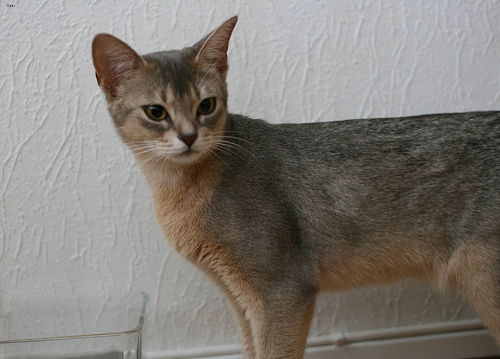

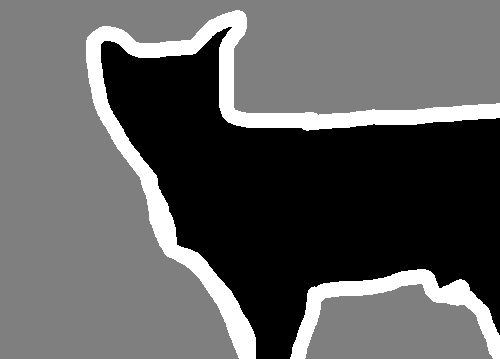

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[50]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[50]))
display(img)

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
class Pets(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
    batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size=self.img_size)
      x[j] = img
    y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.img_size, color_mode="grayscale")
      y[j] = np.expand_dims(img, 2)
      # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
      y[j] -= 1
    return x, y

In [ ]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = Pets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = Pets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 57s 236ms/step - loss: 1.5019 - val_loss: 1.4480
Epoch 2/15
199/199 [==============================] - 46s 233ms/step - loss: 0.5324 - val_loss: 1.6311
Epoch 3/15
199/199 [==============================] - 46s 232ms/step - loss: 0.4355 - val_loss: 0.4159
Epoch 4/15
199/199 [==============================] - 47s 234ms/step - loss: 0.3812 - val_loss: 0.4168
Epoch 5/15
199/199 [==============================] - 47s 236ms/step - loss: 0.3473 - val_loss: 0.3819
Epoch 6/15
199/199 [==============================] - 47s 235ms/step - loss: 0.3154 - val_loss: 0.3649
Epoch 7/15
199/199 [==============================] - 47s 235ms/step - loss: 0.2858 - val_loss: 0.5028
Epoch 8/15
199/199 [==============================] - 47s 234ms/step - loss: 0.2739 - val_loss: 0.3832
Epoch 9/15
199/199 [==============================] - 47s 234ms/step - loss: 0.2494 - val_loss: 0.4845
Epoch 10/15
199/199 [==============================] - 47s 235ms/step - l

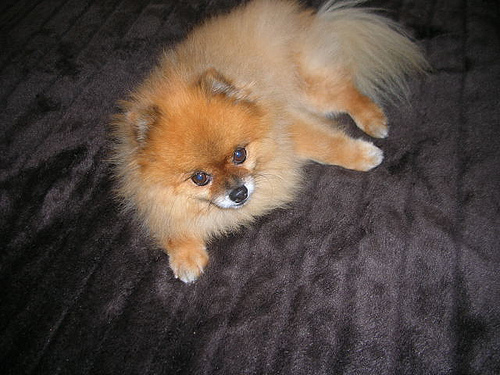

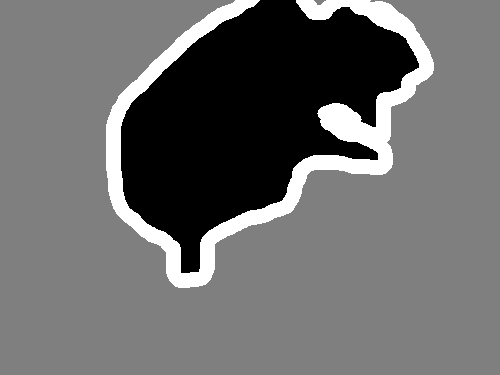

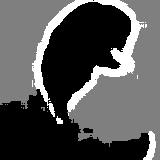

In [ ]:
val_gen = Pets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 30

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)